# Harmonisation:

Comparing the various instruments and applying correction factors to the absoprtion coefficient measurements: 

Here, we harmonise the data sets by applying correction factors to different data sets and merging them together

This notebook produces the figure for ***Figure 1***

In [1]:
import sys

script_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts'

sys.path.append(script_path+'\\Correction_Factors_Absorption')
import Corrections_factors_absorption_functions as fu_cf_abs

sys.path.append(script_path+'\\Trends')
import trends_functions as fu_trends

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import glob
import matplotlib as mpl
from matplotlib import font_manager
import matplotlib.gridspec as gridspec

In [54]:
loadpath = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis'

savepath = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis'

savepathplots = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

Mie = False
mean_or_median = 'mean'

In [3]:
df_rH = fu_cf_abs.load_df(r'C:\Users\DominicHeslinRees\Documents\Analysis\rH_ZEP', 
                          filename='rH_ZEP_1999_2021')

print("Old PSAP EBAS:")
df_oldPSAPEBAS = fu_cf_abs.load_df(loadpath, extrapath=r'absorption\Old_PSAP_EBAS', filename='PSAP_EBAS', formatdata=".dat" )
df_oldPSAPEBAS = df_oldPSAPEBAS.rename(columns={'aerosol_absorption_coefficient':'abs525'})
print(fu_cf_abs.find_number_of_duplicate_indexs(df_oldPSAPEBAS))

old_PSAPEBAS_min = fu_cf_abs.significant_figures(df_oldPSAPEBAS.min().values[0])
print("Minimum value for EBAS: "+str(old_PSAPEBAS_min))  

print("\nNew PSAP:")
df_newpsap =  fu_cf_abs.load_df(loadpath, extrapath=r'absorption\New_PSAP', filename='New_PSAP', formatdata=".dat")
print(fu_cf_abs.find_number_of_duplicate_indexs(df_newpsap))
df_newpsapraw =  fu_cf_abs.load_df(loadpath, extrapath=r'absorption\New_PSAP', filename='RAW_NEW_PSAP_cleaned', formatdata=".dat")

print("\nOld PSAP:")
df_oldpsap =  fu_cf_abs.load_df(loadpath, extrapath=r'absorption\Old_PSAP', filename='Old_PSAP', formatdata=".dat")
print(fu_cf_abs.find_number_of_duplicate_indexs(df_oldpsap))
df_oldpsapraw =  fu_cf_abs.load_df(loadpath, extrapath=r'absorption\Old_PSAP', filename='RAW_Old_PSAP_cleaned', formatdata=".dat")

#off day required 
df_oldpsap = fu_cf_abs.day_offset(df_oldpsap, number_of_days=1, split_time='2012-06-15 16:05:00', add=True, substract=False)
df_oldpsapraw = fu_cf_abs.day_offset(df_oldpsapraw, number_of_days=1, split_time='2012-06-15 16:05:00', add=True, substract=False)

print("\nMAAP:") #df_MAAP_2014_2020_hourly_mean_abs #'hourly_MAAP_mean_extremes'
df_MAAP = fu_cf_abs.load_df(loadpath, extrapath=r'absorption\MAAP', filename='hourly_MAAP_mean_extremes', formatdata=".dat")


loading: C:\Users\DominicHeslinRees\Documents\Analysis\rH_ZEP\rH_ZEP_1999_2021.dat
Old PSAP EBAS:
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\Old_PSAP_EBAS\PSAP_EBAS.dat
Duplicate Rows except first occurrence based on all columns are: 0
DatetimeIndex([], dtype='datetime64[ns]', name='starttime', freq=None)
Minimum value for EBAS: -0.002

New PSAP:
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\New_PSAP\New_PSAP.dat
Duplicate Rows except first occurrence based on all columns are: 0
DatetimeIndex([], dtype='datetime64[ns]', name='Datetime', freq=None)
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\New_PSAP\RAW_NEW_PSAP_cleaned.dat

Old PSAP:
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\Old_PSAP\Old_PSAP.dat
Duplicate Rows except first occurrence based on all columns are: 21026
DatetimeIndex(['2008-09-11 12:29:17', '2008-09-11 12:29:17',
               '2008-09-11 12:29:17'

In [4]:
df_newpsapraw_first, df_newpsapraw_last = fu_cf_abs.remove_duplicates(df_newpsapraw)
listfilters = df_newpsapraw_first['Filter_cum'].unique()
print(len(listfilters))

df_oldpsapraw_first, df_oldpsapraw_last = fu_cf_abs.remove_duplicates(df_oldpsapraw)
listfilters = df_oldpsapraw_first['Filter_cum'].unique()
print(len(listfilters))

Length before: 1535255
Duplicate Rows except first occurrence based on all columns are : 66091
Length after: 1469164
Length after: 1469164
189
Length before: 3851038
Duplicate Rows except first occurrence based on all columns are : 26614
Length after: 3824424
Length after: 3824424
574


In [5]:
df_oldpsapEBAS637 = fu_cf_abs.convert_wavelength(df_oldPSAPEBAS,lambda1=525,lambda2=637,abs_col='abs525',use_constant=True)
df_oldpsap637 = fu_cf_abs.convert_wavelength(df_oldpsap,lambda1=525,lambda2=637,abs_col='abs525',use_constant=True)
df_newpsap637 = fu_cf_abs.convert_wavelength(df_newpsap,lambda1=525,lambda2=637,abs_col='abs525',use_constant=True)

AAE = 1.0 is used to convert between wavelengths for abs525
AAE = 1.0 is used to convert between wavelengths for abs525
AAE = 1.0 is used to convert between wavelengths for abs525


In [6]:
print(df_oldpsap637['Tr'].min())
print(df_newpsap637['Tr'].min())

0.500000506614357
0.5000006741656358


In [7]:
df_stats_table = pd.DataFrame(columns=['R2', 'cf_LMS', 'cf_TS', 'mid_slope', 'number_of_data_points'])

In [8]:
df_newpsap637_hourly = fu_cf_abs.hourly_resample(df_newpsap637, cols=['filter_num', 'abs637', 'scat550', 'Tr']) 
df_merged = fu_cf_abs.mergedfs(df_MAAP, df_newpsap637_hourly) #merge 

Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var'],
      dtype='object')


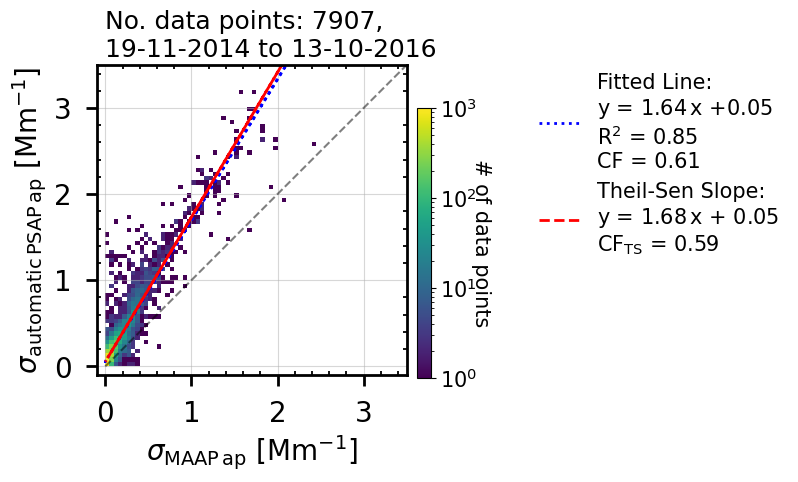

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
fu_cf_abs.produce_density_plot(df_merged, x_var='absorption', y_var='abs637 mean', value_limit=3.5, 
                        step = 0.05, ax=ax)
fu_cf_abs.create_simple_regession_plot(df_merged, x_var='absorption', y_var='abs637 '+str(mean_or_median), 
                            set_max_value=3.5, dict_abs_labels={}, 
                            title='', vmin=0, vmax=1, 
                            xlabel='$\sigma_{\mathrm{MAAP\,ap}}$ [Mm$^{-1}$]', 
                            ylabel='$\sigma_{\mathrm{automatic\,PSAP\,ap}}$ [Mm$^{-1}$]', 
                            show_points=False, ax=ax)

plt.show()

In [10]:
df_newpsap637_hourly = fu_cf_abs.hourly_resample(df_newpsap637, cols=['filter_num', 'abs637', 'scat550', 'Tr']) 
df_merged = fu_cf_abs.mergedfs(df_MAAP, df_newpsap637_hourly) #merge 

Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var'],
      dtype='object')


Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var'],
      dtype='object')
Colour Tr mean


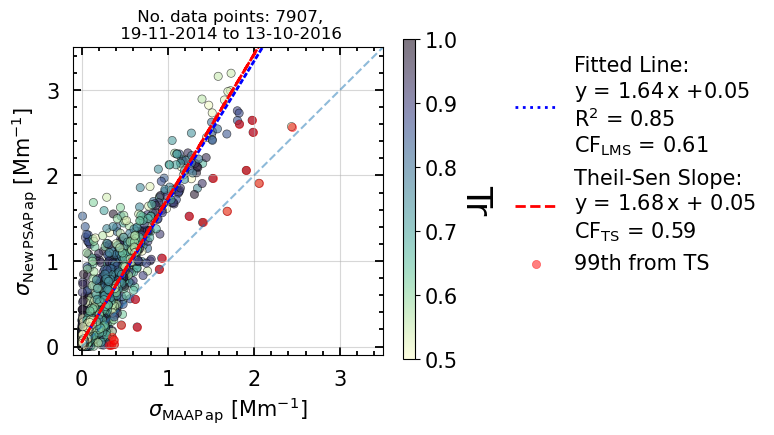

In [11]:
df_newpsap637_hourly = fu_cf_abs.hourly_resample(df_newpsap637, cols=['filter_num', 'abs637', 'scat550', 'Tr']) 
df_merged = fu_cf_abs.mergedfs(df_MAAP, df_newpsap637_hourly) #merge 

fig, dict_stats, df_anomalies = fu_cf_abs.create_regession_plot(df_merged, x_var='absorption', 
                                                                y_var='abs637 '+str(mean_or_median), 
                      c_var='Tr '+str(mean_or_median), set_max_value=3.5, dict_abs_labels={}, 
                      title='', vmin=0, vmax=1, percentile=99, clabel='Tr', 
                      xlabel='$\sigma_{\mathrm{MAAP\,ap}}$ [Mm$^{-1}$]', 
                      ylabel='$\sigma_{\mathrm{New\,PSAP\,ap}}$ [Mm$^{-1}$]')

parameters = [*dict_stats.keys()]
df_stats_table = pd.DataFrame(columns=parameters)
for parameter in parameters:
    df_stats_table.loc['MAAP vs. New PSAP', parameter] = dict_stats[parameter]

Correction factors: LMS = 0.6098116106704493 TS = 0.5949807300787505
2014-11-20 06:00:00    0.229657
2015-07-11 02:00:00    2.571790
Name: abs637 mean, dtype: float64


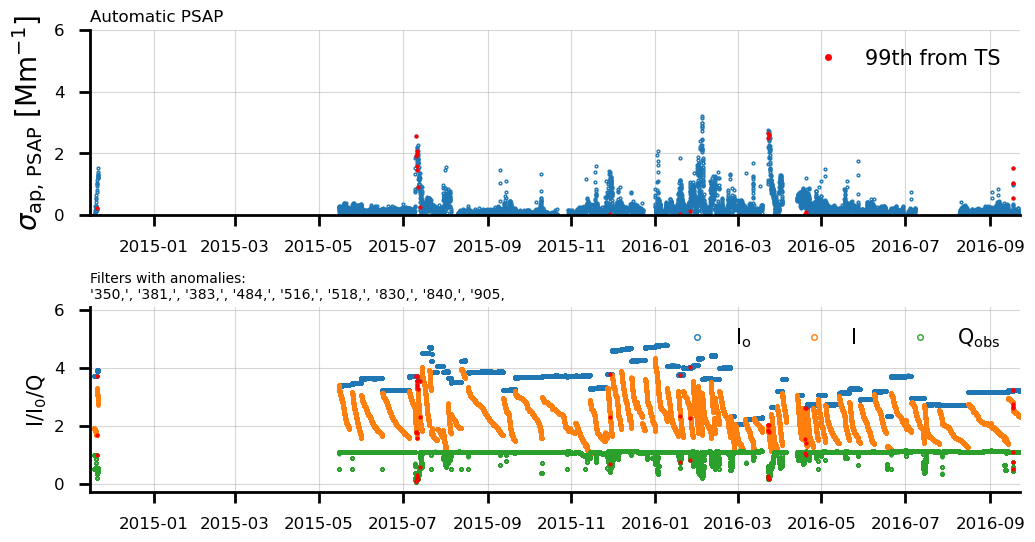

2014-11-20 06:00:00    0.229657
2015-07-11 02:00:00    2.571790
Name: abs637 mean, dtype: float64


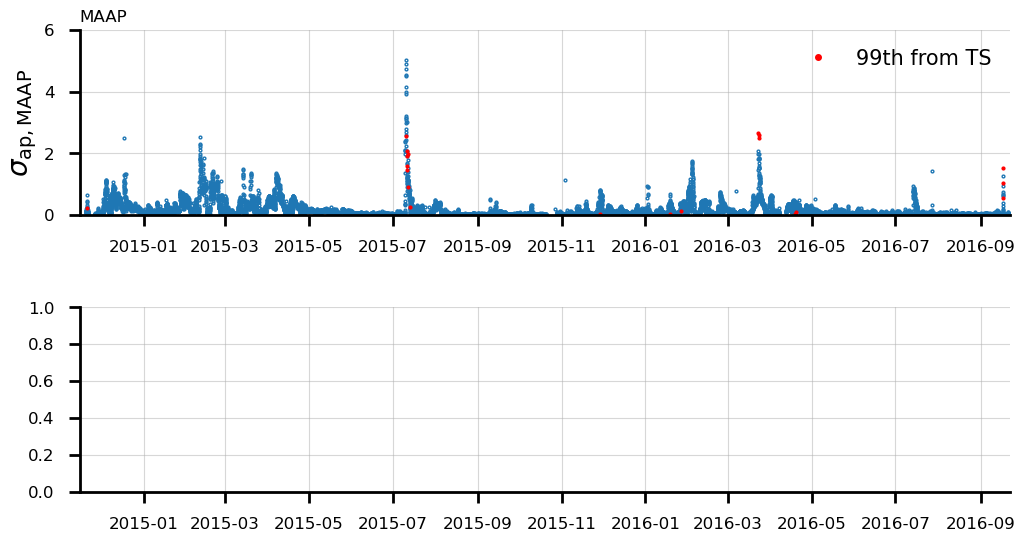

In [12]:
cf_ts = dict_stats['cf_TS']
cf_LMS = dict_stats['cf_LMS']
print("Correction factors: LMS = "+str(cf_LMS)+" TS = "+str(cf_ts))
cf_MAAP_newPSAP = cf_ts

fig, indexes = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_newpsap637_hourly, df_newpsapraw_first,  
                                                   var_main='abs637 '+str(mean_or_median), set_max_value=6,
                                                   var_anomalies='abs637 '+str(mean_or_median), percentile=99, 
                                                   filter_num_col='Filter_cum', label1 = '$\sigma_{\mathrm{ap,\,PSAP}}$ [Mm$^{-1}$]',
                                                   name='Automatic PSAP',label2='I/I$_{0}$/Q', ms=2) 

fig, indexes = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_MAAP, df_newpsapraw_first,  var_main='absorption', 
                                                   set_max_value=6,
                                    var_anomalies='abs637 '+str(mean_or_median), percentile=99, filter_num_col='Filter_cum',
                                    name='MAAP', plot_raw=False, ms=2, label1='$\sigma_{\mathrm{ap, MAAP}}$')

## relative change: 

- C	=	relative change
- x_1	=	initial value
- x_2	=	final value

$\begin{equation}
C=\frac{x_2-x_1}{x_1}
\end{equation}$

In [13]:
def relative_diff(df, var1, var2):
    df['rel_diff'] = (df[var2] - df[var1])/df[var1]
    return df

def fancy(ax, fontsize=20, spines=['top','bottom','left','right'], alpha=0.5):    
    # thickning the axes spines
    for axis in spines:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=alpha)  
    
def get_hours_col(df):
    df['datetime'] = df.index
    df['ordinal'] = df['datetime'].apply(lambda x: x.toordinal())
    df['ordinal'] = df['ordinal'] - df['ordinal'].values[0]
    df['hours'] = df['ordinal']*24+df['datetime'].dt.hour #- df['ordinal'].values[0] 
    return df

def bin_data(df, number_of_bins, var, quantile_based=False):
    df = df.copy()
    if quantile_based == False:
        df['bins'] = pd.cut(df[var], number_of_bins)
    if quantile_based == True:
        df['bins'] = pd.qcut(df[var], number_of_bins)
    df.loc[:, "bin_centres"] = df["bins"].apply(lambda x: x.mid)
    df = df.dropna()
    return df

def q25(x, percentile=0.25):
    return x.quantile(percentile)

def q75(x):
    return x.quantile(0.75)    

def produce_groupby_averages(df, var='abs637'):
    df_groupby = df.groupby('bin_centres', as_index=False)[var].agg(['mean', 'median', 'min', 'max', 'std', q25, q75, 'count']) 
    df_groupby = df_groupby.reset_index()
    return df_groupby

def round_list(lst):
    return [round(x, 2) for x in lst]

def create_boxplot(df, df2, df3, df_merged_binned=None, var='diff_abs637 mean_x', ylabel='', title='', ymin=-1, ymax=None, 
                   letter='',tick_freq=1, freq='5D',
                   CF_value=2.1, CF_LMS=2.24, start='2012-11-21', end='2013-03-14', ax=None):    
    single_figure = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,4))
        single_figure = True
    
    cmap = cmocean.cm.diff
    cmap = 'BrBG_r'
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, 4))
    print(colors)
    
    df.loc[df['count'] < 10, ['mean', 'median', 'min', 'max', 'std', 'q25', 'q75', 'count']] = np.nan
    positions = np.arange(len(df))
    labels_bins = round_list(list(df['bin_centres'].values))    
    for i in range(len(df)):
        bp1 = ax.boxplot(df.iloc[i][['q25', 'median', 'q75']], positions=[positions[i]], widths=0.3, patch_artist=True,
                       )
        for box in bp1['boxes']:
            box.set(facecolor=colors[0], alpha=0.5)
        for whisker in bp1['whiskers']:
            whisker.set(color='k', linewidth=.5, linestyle="-")
        for cap in bp1['caps']:
            cap.set(color='k', linewidth=.5)
        for median in bp1['medians']:
            median.set(color='k', linewidth=1)
        for flier in bp1['fliers']:
            flier.set(marker='D', color=colors[0], alpha=0.5)
            
    df2.loc[df2['count'] < 10, ['mean', 'median', 'min', 'max', 'std', 'q25', 'q75', 'count']] = np.nan
    positions = np.arange(len(df2))
    labels_bins = round_list(list(df2['bin_centres'].values))    
    for i in range(len(df2)):
        bp2 = ax.boxplot(df2.iloc[i][['q25', 'median', 'q75']], positions=[positions[i]], widths=0.3, patch_artist=True,)
        for box in bp2['boxes']:
            box.set(facecolor=colors[1], alpha=0.5)
        for whisker in bp2['whiskers']:
            whisker.set(color='k', linewidth=.5, linestyle="-")
        for cap in bp2['caps']:
            cap.set(color='k', linewidth=.5)
        for median in bp2['medians']:
            median.set(color='k', linewidth=1)
        for flier in bp2['fliers']:
            flier.set(marker='D', color=colors[1], alpha=0.5)
            
    if df3 is not None:            
        df3.loc[df3['count'] < 10, ['mean', 'median', 'min', 'max', 'std', 'q25', 'q75', 'count']] = np.nan
        positions = np.arange(len(df3))
        labels_bins = round_list(list(df3['bin_centres'].values))    
        for i in range(len(df3)):
            bp3 = ax.boxplot(df3.iloc[i][['q25', 'median', 'q75']], positions=[positions[i]], widths=0.3, patch_artist=True,)
            for box in bp3['boxes']:
                box.set(facecolor=colors[2], alpha=0.5)
            for whisker in bp3['whiskers']:
                whisker.set(color='k', linewidth=.5, linestyle="-")
            for cap in bp3['caps']:
                cap.set(color='k', linewidth=.5)
            for median in bp3['medians']:
                median.set(color='k', linewidth=1)
            for flier in bp3['fliers']:
                flier.set(marker='D', color=colors[2], alpha=0.5)
       
    label_dates = pd.date_range(start=start, end=end, freq=freq)
    label_dates = [str(x.date()) for x in label_dates]    
    ticks = list(np.arange(0, len(label_dates), tick_freq))    
    ax.set_xticks(ticks, label_dates[::tick_freq], rotation=90)    
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=15)
        
    fancy(ax, fontsize=12)
    total_count = int(df['count'].sum())+int(df2['count'].sum())
    if df3 is not None: 
        total_count = int(df['count'].sum())+int(df2['count'].sum())+int(df3['count'].sum())
        
    ax.set_title(letter+' '+'(N = '+str(total_count)+')', loc='left')
    ax.set_ylim(ymin, ymax)
    
    if df3 is not None:  
        ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], 
                  ['AHZ', 'SUM', 'SBU'], loc='upper right', frameon=False)
    if df is None:
        ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['AHZ', 'SBU'], loc='upper right', frameon=False,
                  ncol=2)
    
    ax2 = ax.twinx()
    ax2.axhline(y=1, c='k', ls=':', label='1:1')
    ax2.axhline(y=CF_value, c='r', ls='--', label='CF$_{\mathrm{TS}}$ ='+str(CF_value))
    ax2.axhline(y=CF_LMS, c='r', ls=':', label='CF$_{\mathrm{LMS}}$ ='+str(CF_LMS))    
    ax2.set_ylim(ymin, ymax)   
    ax2.legend(frameon=False, loc="upper left", ncol=2)
    ax2.get_yaxis().set_visible(False)
    
    if df_merged_binned is not None:
        diff_mean = df_merged_binned[var].mean()
        diff_median = df_merged_binned[var].median()    
        diff_mean = "{:.2f}".format(diff_mean)
        diff_median = "{:.2f}".format(diff_median)
        ax2.axhline(y=diff_mean, c='b', ls='--', label='Mean diff. ='+str(diff_mean))
        #ax2.axhline(y=diff_median, c='b', ls=':', label='Median diff. ='+str(diff_median))

    if single_figure == True:
        plt.show()    
        return fig
    if single_figure == False:
        return ax

In [14]:
def limit_df(df, x_var, y_var, xmin=0, xmax=60, ymin=0, ymax=60):
    df = fu_cf_abs.limit_dfs_values(df, x_var, y_var, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax) #limits    
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)] #remove any infs or np.nan  
    return df

In [15]:
df_merged = fu_cf_abs.mergedfs(df_MAAP, df_newpsap637_hourly) #merge
df_merged = limit_df(df_merged, x_var='abs637 '+str(mean_or_median), y_var='absorption')

df_merged_ = relative_diff(df_merged, var2='abs637 '+str(mean_or_median),
                          var1='absorption')
df_merged_ = get_hours_col(df_merged_)

df_merged_seasons = fu_trends.prepare_data(df_merged_)

df_merged_binned = bin_data(df_merged_seasons, number_of_bins=list(np.arange(0, 694, 20)), var='ordinal', 
                            quantile_based=False)

df_merged_groupby = produce_groupby_averages(df_merged_binned, var='rel_diff')

df_merged_binned_ = df_merged_binned.reset_index()

df_AHZ = df_merged_binned_[df_merged_binned_['season_abb'] == 'AHZ'].copy()
df_SUM = df_merged_binned_[df_merged_binned_['season_abb'] == 'SUM'].copy()
df_SBU = df_merged_binned_[df_merged_binned_['season_abb'] == 'SBU'].copy()

df_merged_groupby_AHZ = produce_groupby_averages(df_AHZ, var='rel_diff')
df_merged_groupby_SUM = produce_groupby_averages(df_SUM, var='rel_diff')
df_merged_groupby_SBU = produce_groupby_averages(df_SBU, var='rel_diff')

start date inserted: 2014-11-19
start year: 2014
end year: 2016
number years: 2
first season: SBU
SBU
2014
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 7
full_season_to_season_num given


In [16]:
df_merged_AHZ = df_merged_seasons[df_merged_seasons['season_abb'] == 'AHZ']
df_merged_SUM = df_merged_seasons[df_merged_seasons['season_abb'] == 'SUM']
df_merged_SBU = df_merged_seasons[df_merged_seasons['season_abb'] == 'SBU']

C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

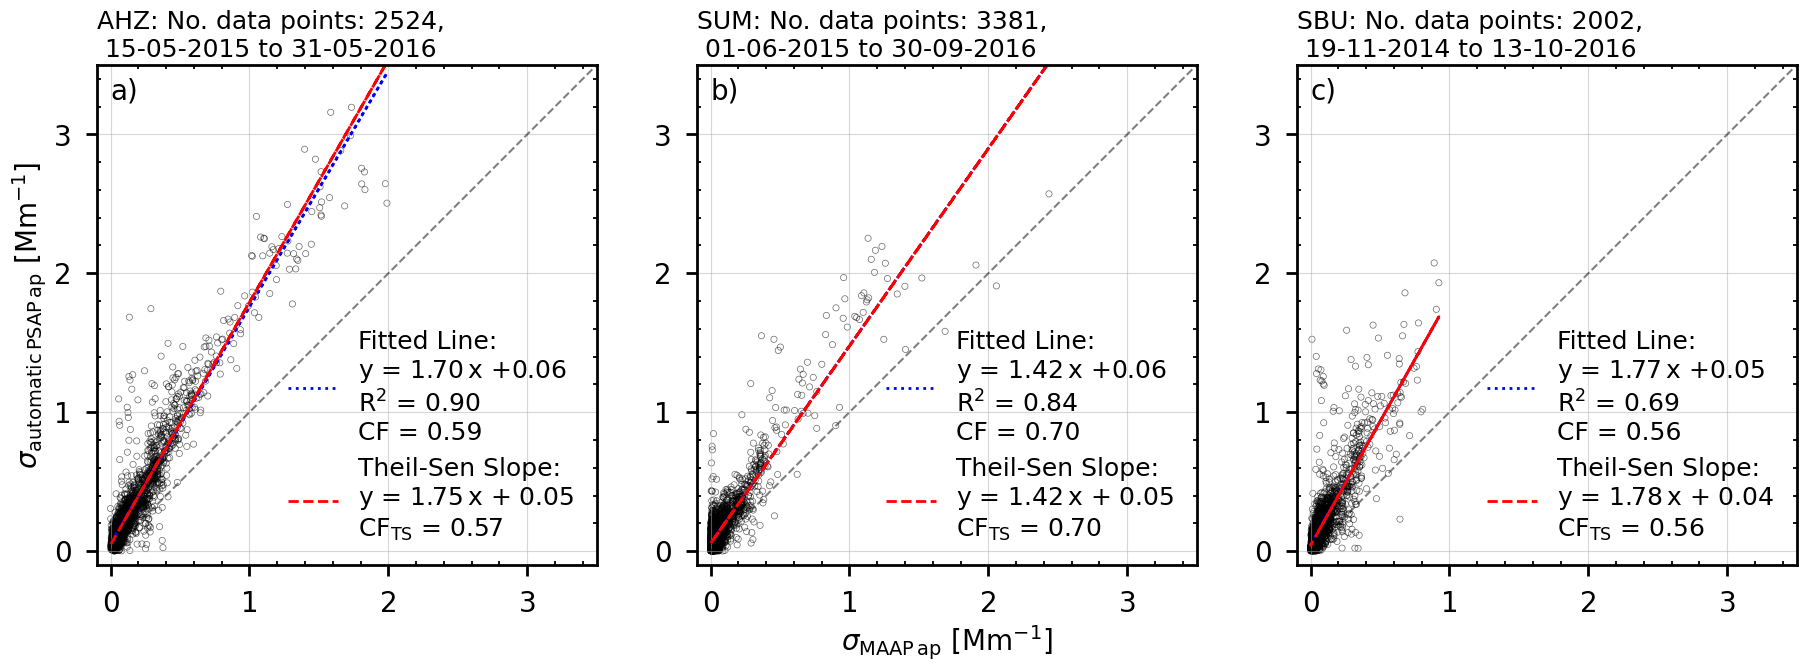

In [17]:
fig = plt.figure(figsize=(17, 5))

gs = gridspec.GridSpec(ncols=3, nrows=1, hspace = 0.2, wspace = 0.2, top = 1,
                       bottom = 0, left = 0, right = 1)

ax1 = fig.add_subplot(gs[0])
ax1.text(0.001, 3.25, 'a)', fontsize=20, color='k', )

fu_cf_abs.create_simple_regession_plot(df_merged_AHZ, x_var='absorption', 
                      y_var='abs637 '+str(mean_or_median), 
                      set_max_value=3.5, dict_abs_labels={}, s=20,
                      title='AHZ:', vmin=0, vmax=1, percentile=99, legend_out_of_box=False,
                      xlabel='', 
                      ylabel='$\sigma_{\mathrm{automatic \,PSAP\,ap}}$ [Mm$^{-1}$]', ax=ax1)


ax2 = fig.add_subplot(gs[1])
ax2.text(0.001, 3.25, 'b)', fontsize=20, color='k', )

fu_cf_abs.create_simple_regession_plot(df_merged_SUM, x_var='absorption', 
                      y_var='abs637 '+str(mean_or_median), 
                      set_max_value=3.5, dict_abs_labels={}, s=20,
                      title='SUM:', vmin=0, vmax=1, percentile=99, legend_out_of_box=False,
                      xlabel='$\sigma_{\mathrm{MAAP\,ap}}$ [Mm$^{-1}$]', 
                      ylabel='', ax=ax2)

ax3 = fig.add_subplot(gs[2])
ax3.text(0.001, 3.25, 'c)', fontsize=20, color='k', )

fu_cf_abs.create_simple_regession_plot(df_merged_SBU, x_var='absorption', 
                      y_var='abs637 '+str(mean_or_median), 
                      set_max_value=3.5, dict_abs_labels={}, s=20,
                      title='SBU:', vmin=0, vmax=1, percentile=99, legend_out_of_box=False,
                      xlabel='', 
                      ylabel='', ax=ax3)
plt.show()

[[0.         0.23529412 0.18823529 1.        ]
 [0.59477124 0.84183007 0.80392157 1.        ]
 [0.90457516 0.81045752 0.58169935 1.        ]
 [0.32941176 0.18823529 0.01960784 1.        ]]


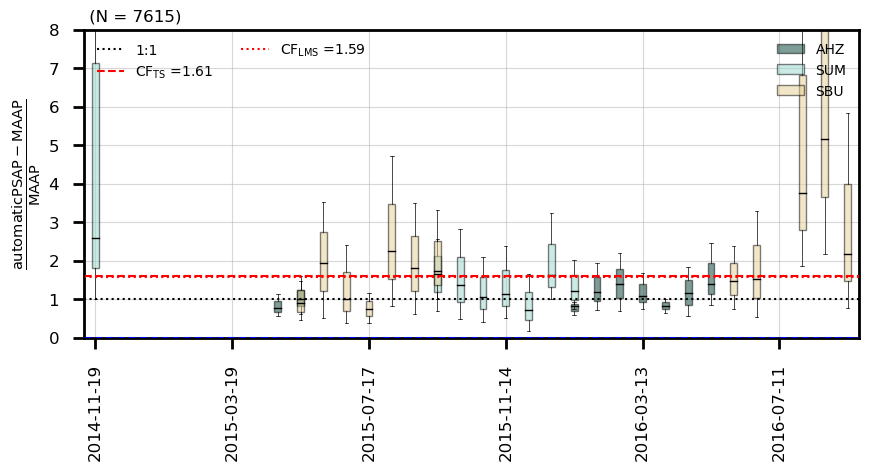

In [18]:
label=r'$\frac{\mathrm{automatic PSAP-MAAP}}{\mathrm{MAAP}}$'
fig = create_boxplot(df_merged_groupby_AHZ, df_merged_groupby_SBU, df_merged_groupby_SUM, df_merged_binned_, 
                     var='rel_diff',
                     ylabel=label, title='', ymax=8, letter='', CF_value=1.61, CF_LMS=1.59, ymin=0, tick_freq=6,
                     start='2014-11-19', end='2016-10-08', freq='20D', ax=None)

# PSAP New vs. Old: 

Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var',
       'volume mean', 'volume median', 'volume std', 'volume var'],
      dtype='object')
Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var',
       'volume mean', 'volume median', 'volume std', 'volume var'],
      dtype='object')
Colour volume mean_y


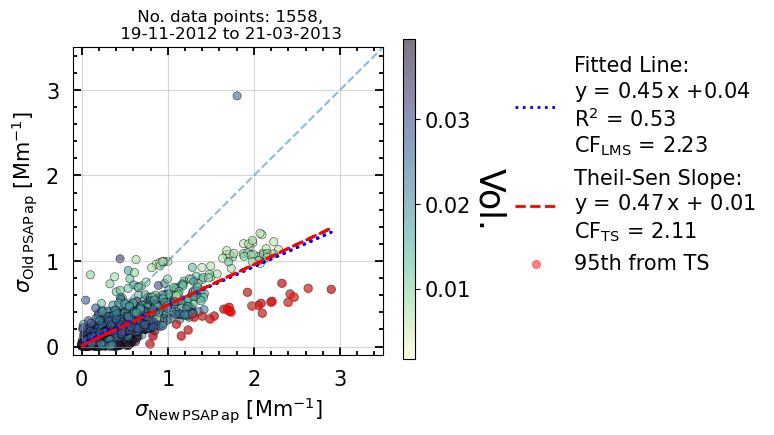

Correction factors: LMS = 2.227434052981325 TS = 2.112614862128675


In [19]:
df_newpsap637_hourly = fu_cf_abs.hourly_resample(df_newpsap637, 
                                                 cols=['filter_num', 'abs637', 'scat550', 'Tr', 'volume']) #hourly
df_oldpsap637_hourly = fu_cf_abs.hourly_resample(df_oldpsap637, 
                                                 cols=['filter_num', 'abs637', 'scat550', 'Tr', 'volume']) #hourly
df_merged = fu_cf_abs.mergedfs(df_newpsap637_hourly, df_oldpsap637_hourly) # merge 

fig, dict_stats, df_anomalies = fu_cf_abs.create_regession_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_x', 
                                                               y_var='abs637 '+str(mean_or_median)+'_y', 
                                                               c_var='volume '+str(mean_or_median)+'_y', 
                                                               set_max_value=3.5, dict_abs_labels={}, 
                                                               title='', vmin=0, vmax=1, percentile=95, 
                                                               clabel='Vol.', 
                                                               xlabel='$\sigma_{\mathrm{New\,PSAP\,ap}}$ [Mm$^{-1}$]', 
                                                               ylabel='$\sigma_{\mathrm{Old\,PSAP\,ap}}$ [Mm$^{-1}$]')
cf_ts = dict_stats['cf_TS']
cf_LMS = dict_stats['cf_LMS']
print("Correction factors: LMS = "+str(cf_LMS)+" TS = "+str(cf_ts))
cf_newPSAP_oldPSAP = cf_ts

Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var',
       'volume mean', 'volume median', 'volume std', 'volume var'],
      dtype='object')
Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var',
       'volume mean', 'volume median', 'volume std', 'volume var'],
      dtype='object')
Correction factors: LMS = 2.227434052981325 TS = 2.112614862128675


C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\Correction_Factors_Absorption\Corrections_factors_absorption_functions.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalies['y_predict'] = med_intercept + mid_slope*df_anomalies[x_var]


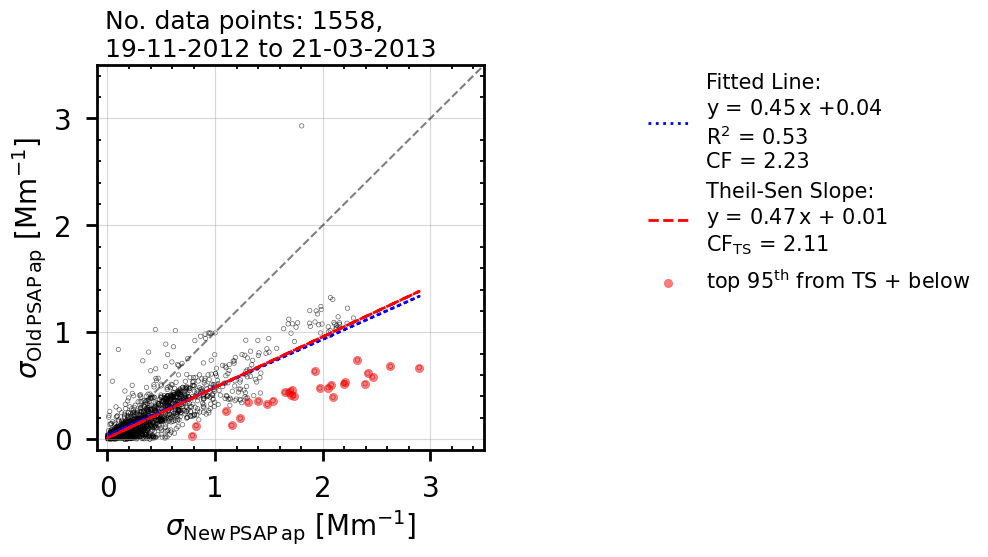

In [20]:
df_newpsap637_hourly = fu_cf_abs.hourly_resample(df_newpsap637, 
                                                 cols=['filter_num', 'abs637', 'scat550', 'Tr', 'volume']) #hourly
df_oldpsap637_hourly = fu_cf_abs.hourly_resample(df_oldpsap637, 
                                                 cols=['filter_num', 'abs637', 'scat550', 'Tr', 'volume']) #hourly
df_merged = fu_cf_abs.mergedfs(df_newpsap637_hourly, df_oldpsap637_hourly) # merge 

fig, ax = plt.subplots(figsize=(5,5))
fu_cf_abs.create_simple_regession_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_x', 
                                                               y_var='abs637 '+str(mean_or_median)+'_y',                                                               
                                                               set_max_value=3.5, dict_abs_labels={}, 
                                                               title='', vmin=0, vmax=1, percentile=95,
                                                               plot_annomalies=True,
                                                               loc_legend='upper left',
                                                               xlabel='$\sigma_{\mathrm{New\,PSAP\,ap}}$ [Mm$^{-1}$]', 
                                                               ylabel='$\sigma_{\mathrm{Old\,PSAP\,ap}}$ [Mm$^{-1}$]',
                                                               ax=ax)
cf_ts = dict_stats['cf_TS']
cf_LMS = dict_stats['cf_LMS']
print("Correction factors: LMS = "+str(cf_LMS)+" TS = "+str(cf_ts))
cf_newPSAP_oldPSAP = cf_ts

plt.show()

2012-12-29 19:00:00    0.824057
2013-01-21 12:00:00    1.100412
Name: abs637 mean_x, dtype: float64


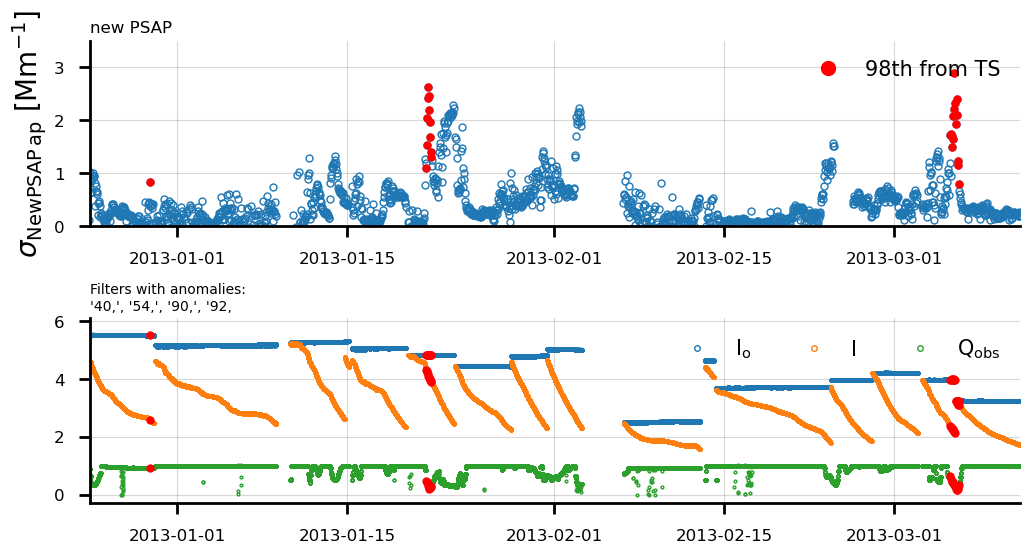

make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\\newpsap_annomalies.jpeg


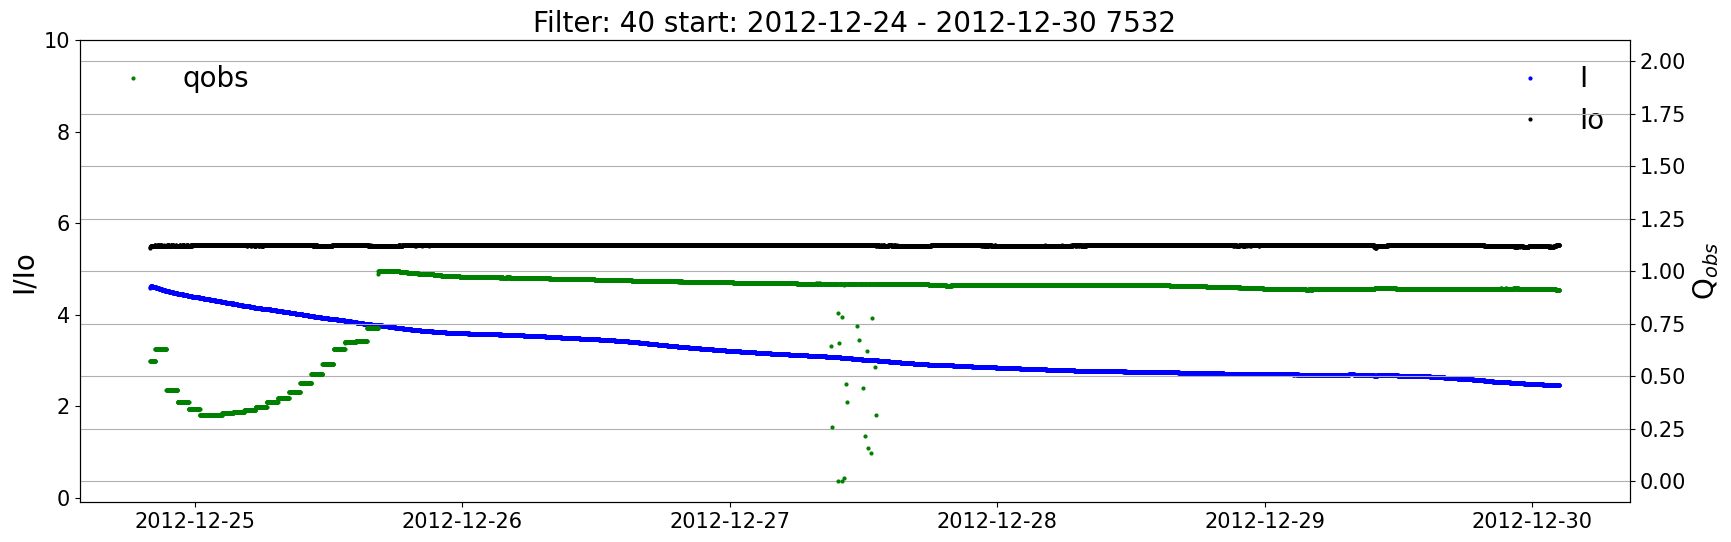

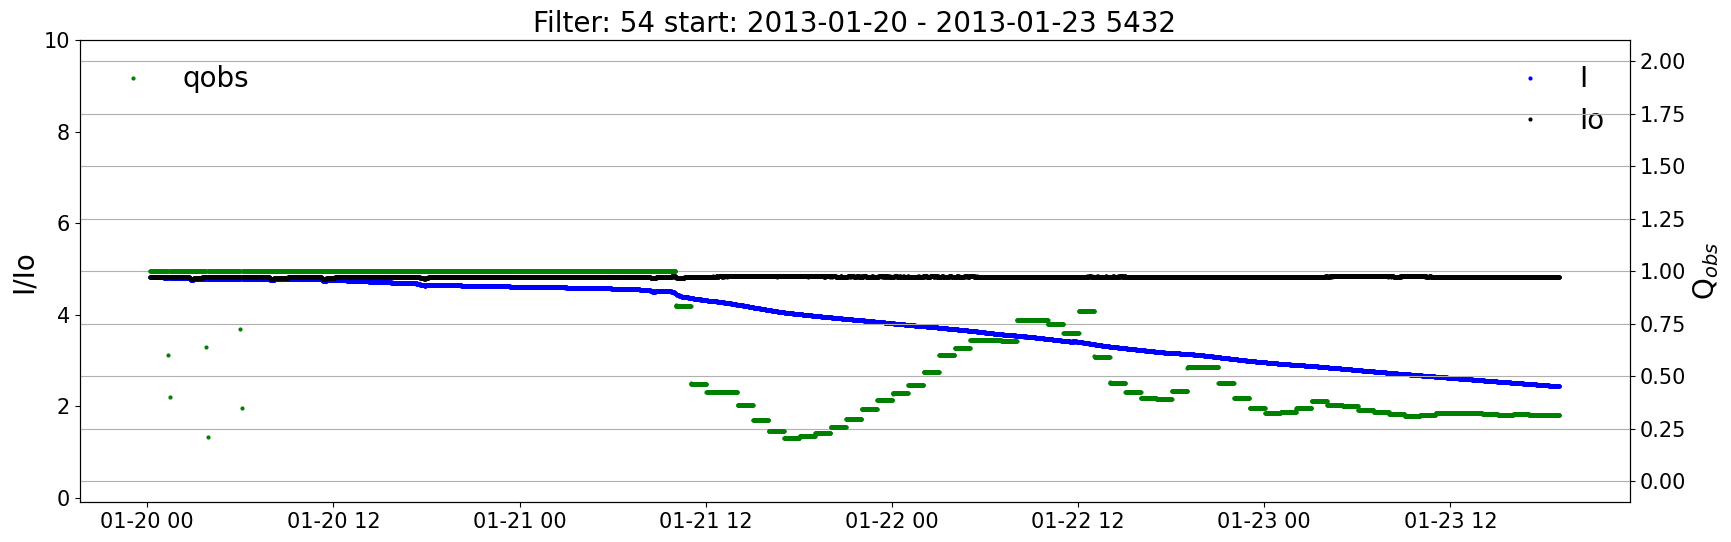

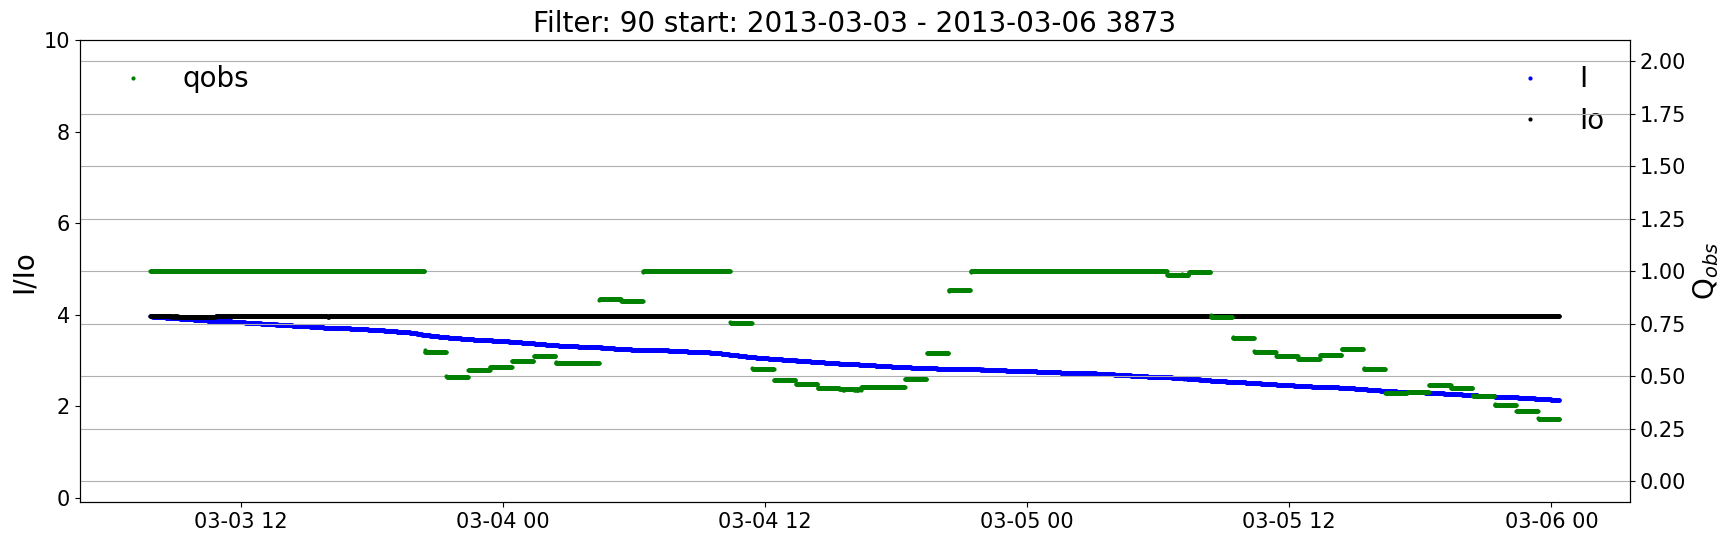

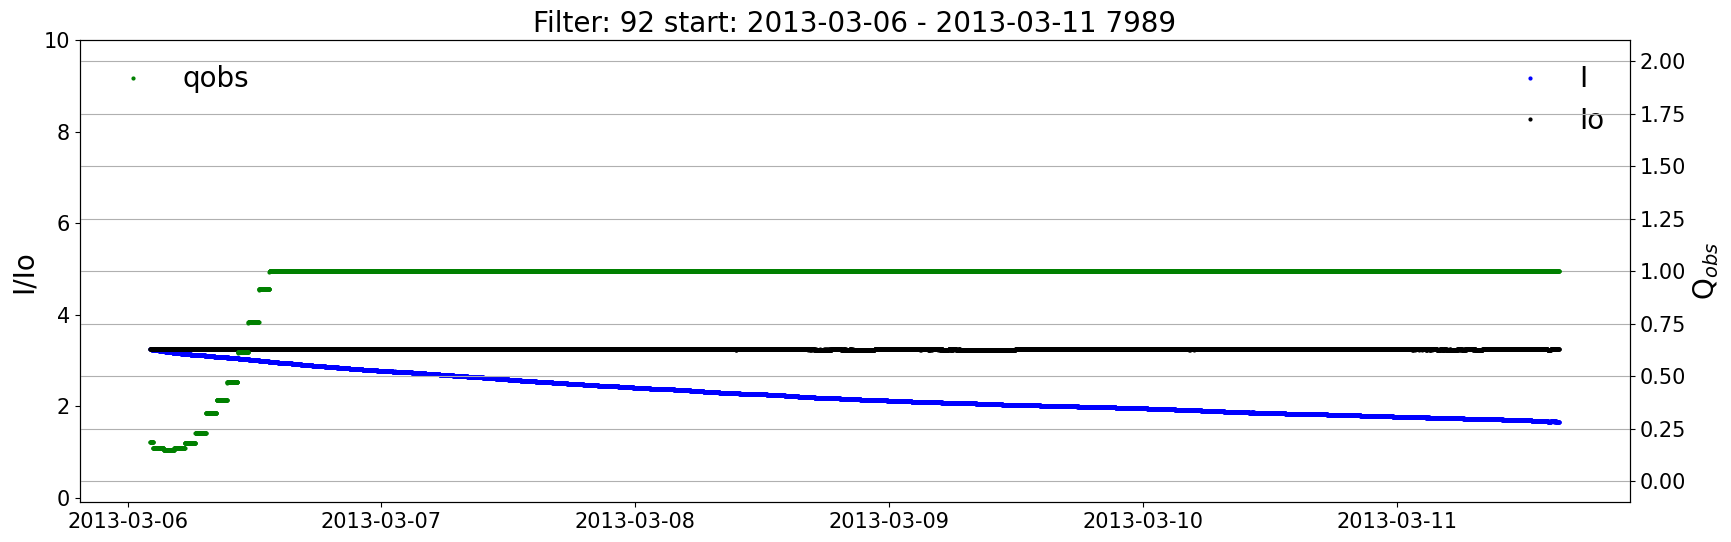

2012-12-29 19:00:00    0.128068
2013-01-21 12:00:00    0.263313
Name: abs637 mean_y, dtype: float64


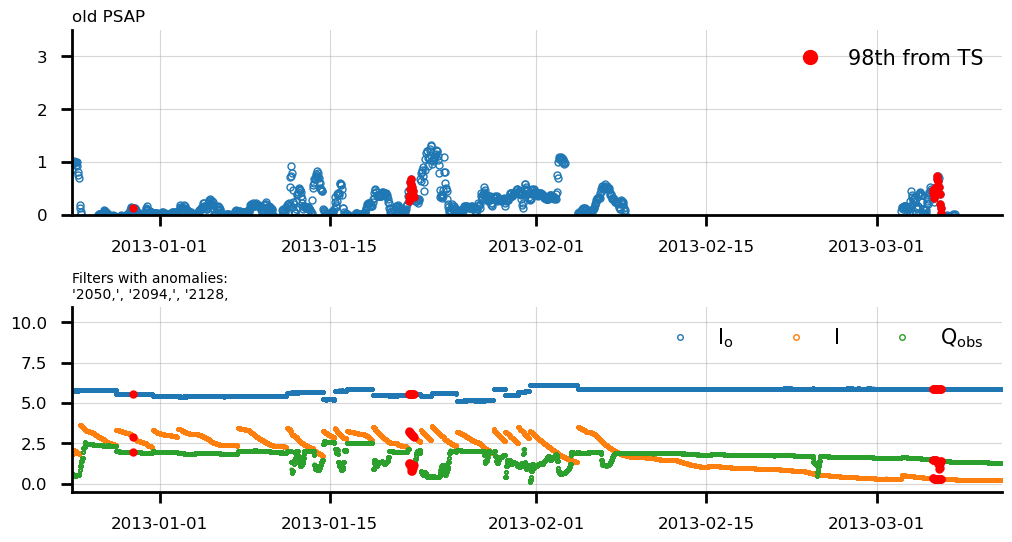

In [21]:
fig, indexes_newpsap = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_newpsap637_hourly, df_newpsapraw_first, 
                                            var_main='abs637 '+str(mean_or_median)+'', 
                                            var_anomalies='abs637 '+str(mean_or_median)+'_x', 
                                            percentile=98, filter_num_col='Filter_cum',
                                            set_max_value=3.5, name='new PSAP',
                                            label1='$\sigma_{\mathrm{New PSAP\,ap}}$ [Mm$^{-1}$]',
                                            label2='',labelMie='') 
fu_cf_abs.save_plot(fig, name='newpsap_annomalies')

for filter_num in indexes_newpsap:
    fu_cf_abs.plot_each_filter(df_newpsapraw_first,  filter_num=filter_num, filter_var='Filter_cum')

fig, indexes_oldpsap = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_oldpsap637_hourly, df_oldpsapraw_first, 
                                            var_main='abs637 '+str(mean_or_median), 
                                            var_anomalies='abs637 '+str(mean_or_median)+'_y', 
                                            percentile=98, filter_num_col='Filter_cum',
                                            set_max_value=3.5, name='old PSAP') 

In [22]:
df_merged_ = relative_diff(df_merged, var1='abs637 '+str(mean_or_median)+'_x', 
              var2='abs637 '+str(mean_or_median)+'_y',)
df_merged_ = get_hours_col(df_merged_)

daily = df_merged_.resample('D').mean()['rel_diff'].to_frame()
df_merged_seasons = fu_trends.prepare_data(df_merged_)

df_merged_binned = bin_data(df_merged_seasons, number_of_bins=list(np.arange(0, 122, 5)), var='ordinal', quantile_based=False)

df_merged_groupby = produce_groupby_averages(df_merged_binned, var='rel_diff')
df_merged_binned_ = df_merged_binned.reset_index()

start date inserted: 2012-11-19
start year: 2012
end year: 2013
number years: 1
first season: SBU
SBU
2012
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 4
full_season_to_season_num given


In [23]:
SBU_bins = list(df_merged_binned.loc[df_merged_binned['season_abb'] == 'SBU', 'bin_centres'].unique())
AHZ_bins = list(df_merged_binned.loc[df_merged_binned['season_abb'] == 'AHZ', 'bin_centres'].unique())

In [24]:
SBU_bins = list(df_merged_binned_[df_merged_binned_['season_abb'] == 'SBU'].index)
AHZ_bins = list(df_merged_binned_[df_merged_binned_['season_abb'] == 'AHZ'].index)

In [25]:
df_AHZ = df_merged_binned_[df_merged_binned_['season_abb'] == 'AHZ'].copy()
df_SBU = df_merged_binned_[df_merged_binned_['season_abb'] == 'SBU'].copy()

In [26]:
df_merged_groupby_AHZ = produce_groupby_averages(df_AHZ, var='rel_diff')
df_merged_groupby_SBU = produce_groupby_averages(df_SBU, var='rel_diff')

In [27]:
df_merged_groupby_AHZ.head(2)

,bin_centres,mean,median,min,max,std,q25,q75,count
0,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


[[0.         0.23529412 0.18823529 1.        ]
 [0.59477124 0.84183007 0.80392157 1.        ]
 [0.90457516 0.81045752 0.58169935 1.        ]
 [0.32941176 0.18823529 0.01960784 1.        ]]


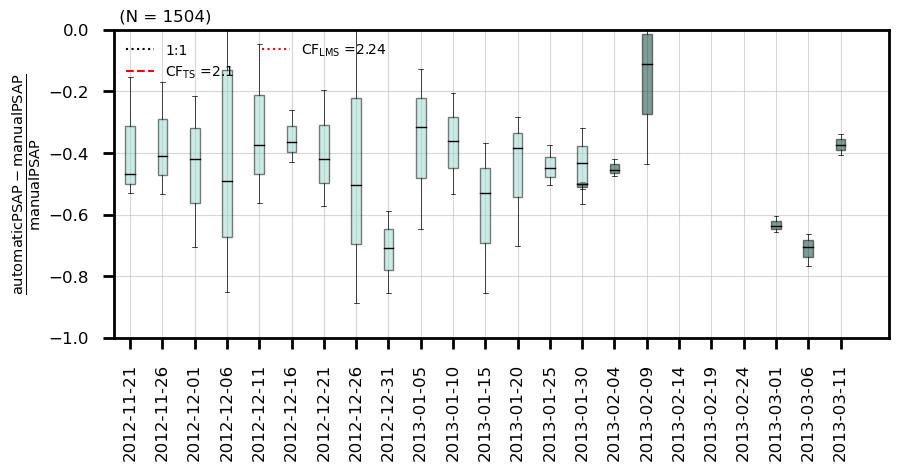

In [28]:
label=r'$\frac{\mathrm{automatic PSAP-manual PSAP}}{\mathrm{manual PSAP}}$'
fig = create_boxplot(df_merged_groupby_AHZ, df_merged_groupby_SBU, df3=None, ylabel=label, 
                     title='', letter='', CF_LMS=2.24, ymin=-1, ymax=0, ax=None)

# DMPS Data: 

In [29]:
loadpath_Mie_DMPS = loadpath+'\\Mie_DMPS'

df_DMPS_2010_2020 = pd.read_csv(loadpath_Mie_DMPS+"\\DMPS_2010_2020.dat", index_col=0, parse_dates=True)
df_DMPS_2010_2020['sum'] = df_DMPS_2010_2020.sum(axis=1)

df_2000_2005_Mie = pd.read_csv(loadpath_Mie_DMPS+"\\df_2000_2005_Mie.dat", index_col=0, parse_dates=True)
df_2006_2009_Mie = pd.read_csv(loadpath_Mie_DMPS+"\\df_2006_2009_Mie.dat", index_col=0, parse_dates=True)
df_2010_2020_Mie = pd.read_csv(loadpath_Mie_DMPS+"\\df_2010_2020_Mie.dat", index_col=0, parse_dates=True)

df_2000_2020_Mie = pd.concat([df_2000_2005_Mie, df_2006_2009_Mie, df_2010_2020_Mie])
df_2000_2020_Mie = df_2000_2020_Mie.replace(0, np.nan)

df_2000_2020_Mie['Mie'] = True

df_2000_2020_Mie = df_2000_2020_Mie.sort_index()

2012-12-29 19:00:00    0.824057
2013-01-21 12:00:00    1.100412
Name: abs637 mean_x, dtype: float64
DateTime
2010-08-03 00:00:00    4876.8280
2010-08-03 01:00:00    4174.8755
2010-08-03 02:00:00    3326.1350
2010-08-03 03:00:00    4825.7840
2010-08-03 04:00:00          NaN
                         ...    
2020-12-31 19:00:00    1206.1300
2020-12-31 20:00:00    1151.6870
2020-12-31 21:00:00    1145.0675
2020-12-31 22:00:00     936.9340
2020-12-31 23:00:00     688.3415
Freq: 60T, Name: sum, Length: 91296, dtype: float64


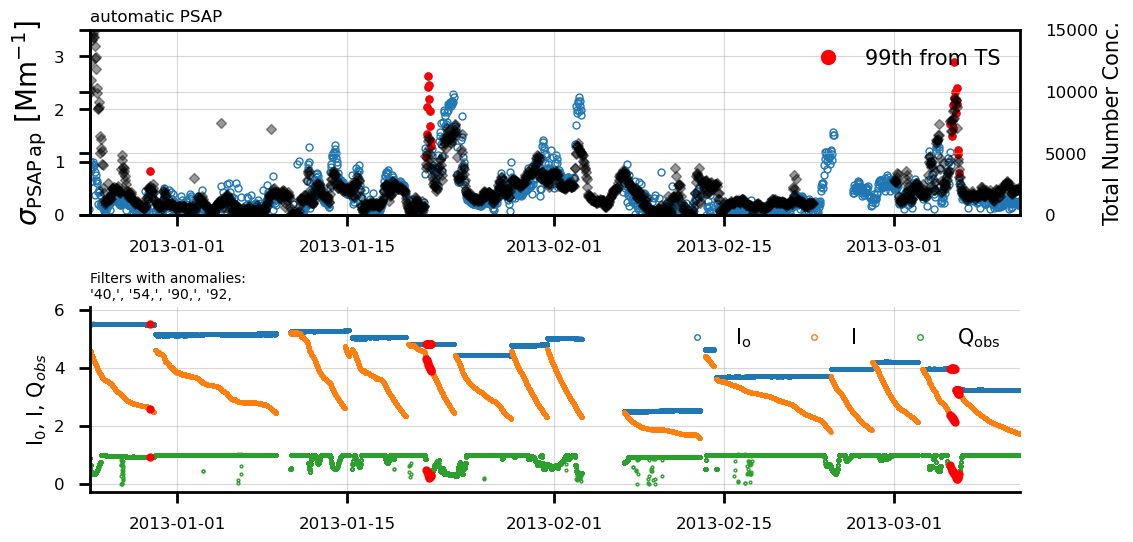

In [30]:
df_DMPS_2010_2020_hourly = df_DMPS_2010_2020.resample('60T').median() #the size distribution is every 30 minu
df_merged = fu_cf_abs.mergedfs(df_newpsap637_hourly, df_DMPS_2010_2020_hourly) # merge 
fig, indexes_newpsap = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_newpsap637_hourly, df_newpsapraw_first, var_main='abs637 '+str(mean_or_median), 
                          var_anomalies='abs637 '+str(mean_or_median)+'_x', percentile=99, 
                          filter_num_col='Filter_cum',
                          set_max_value=3.5, name='automatic PSAP', df_Mie=df_DMPS_2010_2020_hourly,
                          Mie_var='sum', Miemax=15000, 
                          label1='$\sigma_{\mathrm{PSAP\,ap}}$ [Mm$^{-1}$]',
                          label2='I$_{0}$, I, Q$_{obs}$', labelMie='Total Number Conc.') 

2012-12-29 19:00:00    0.824057
2013-01-21 12:00:00    1.100412
Name: abs637 mean_x, dtype: float64
DateTime
2010-08-03 00:00:00    1.263759
2010-08-03 01:00:00    0.812578
2010-08-03 02:00:00    0.472881
2010-08-03 03:00:00    1.110636
2010-08-03 04:00:00    0.000000
                         ...   
2020-12-31 19:00:00    3.289142
2020-12-31 20:00:00    2.681510
2020-12-31 21:00:00    3.358542
2020-12-31 22:00:00    1.647563
2020-12-31 23:00:00    1.052525
Name: scat550, Length: 91296, dtype: float64


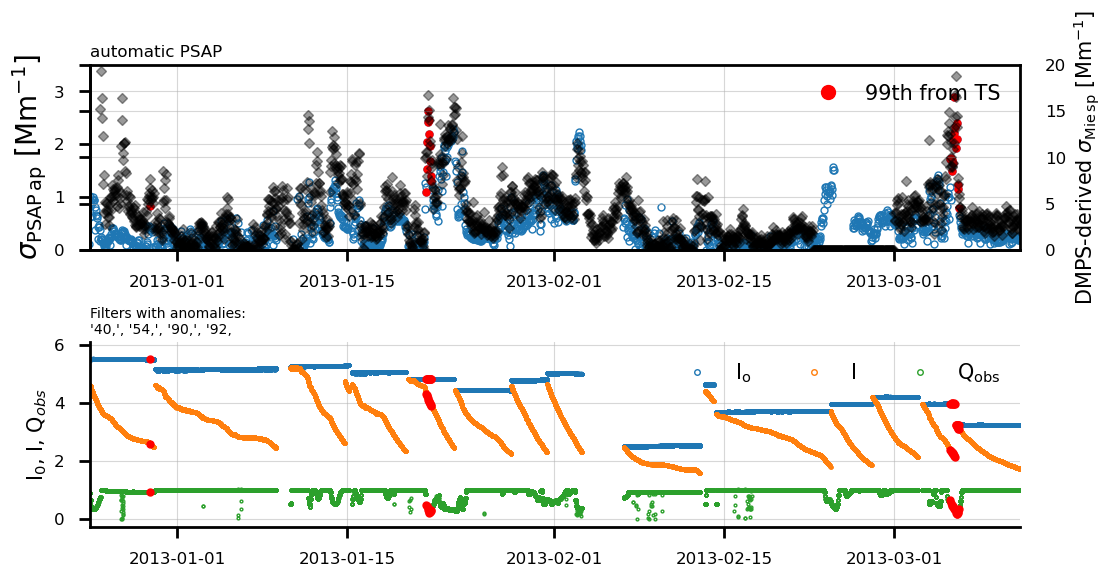

In [31]:
df_DMPS_2010_2020_hourly = df_DMPS_2010_2020.resample('60T').median() #the size distribution is every 30 minu
df_merged = fu_cf_abs.mergedfs(df_newpsap637_hourly, df_DMPS_2010_2020_hourly) # merge 


fig, indexes_newpsap = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_newpsap637_hourly, df_newpsapraw_first, var_main='abs637 '+str(mean_or_median), 
                                    var_anomalies='abs637 '+str(mean_or_median)+'_x', percentile=99, 
                                    filter_num_col='Filter_cum',
                                    set_max_value=3.5, name='automatic PSAP', df_Mie=df_2010_2020_Mie,
                                    Mie_var='scat550', Miemax=20, label1='$\sigma_{\mathrm{PSAP\,ap}}$ [Mm$^{-1}$]',
                                    labelMie='DMPS-derived $\sigma_{\mathrm{Mie\,sp}}$ [Mm$^{-1}$]',
                                    label2='I$_{0}$, I, Q$_{obs}$') 

2012-12-29 19:00:00    0.824057
2013-01-21 12:00:00    1.100412
Name: abs637 mean_x, dtype: float64
starttime
1999-01-01 20:00:00.028800    89.6
1999-01-01 20:59:59.971200    89.6
1999-01-01 22:00:00.000000    89.6
1999-01-01 23:00:00.028800    89.4
1999-01-01 23:59:59.971200    89.4
                              ... 
2021-12-31 19:00:00.028800    59.8
2021-12-31 19:59:59.971200    61.8
2021-12-31 21:00:00.000000    55.4
2021-12-31 22:00:00.028800    57.6
2021-12-31 22:59:59.971200    51.5
Name: rH, Length: 179792, dtype: float64


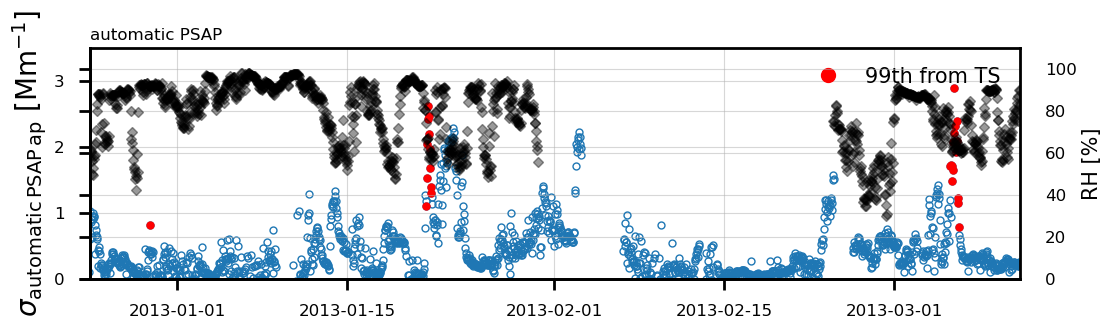

In [32]:
fig = fu_cf_abs.create_annomly_timeseries(df_anomalies, df_newpsap637_hourly, df_newpsapraw_first, 
                                                           var_main='abs637 '+str(mean_or_median), 
                                                           var_anomalies='abs637 '+str(mean_or_median)+'_x', percentile=99, 
                                                           filter_num_col='Filter_cum',
                                                           set_max_value=3.5, name='automatic PSAP', df_Mie=df_rH,
                                                            Mie_var='rH', Miemax=110, 
                                                           label1='$\sigma_{\mathrm{automatic\,PSAP\,ap}}$ [Mm$^{-1}$]',
                                                           labelMie='RH [%]', plot_ax1_only=True) 

# Apply corrections: 

In [33]:
df_newpsap637_hourly = fu_cf_abs.apply_correction(df_newpsap637_hourly, cf_MAAP_newPSAP, 
                                                   mean_or_median, var='abs637')

Applying correction factor of 0.5949807300787505
new variable: abs637 mean_cf


Colour Tr mean


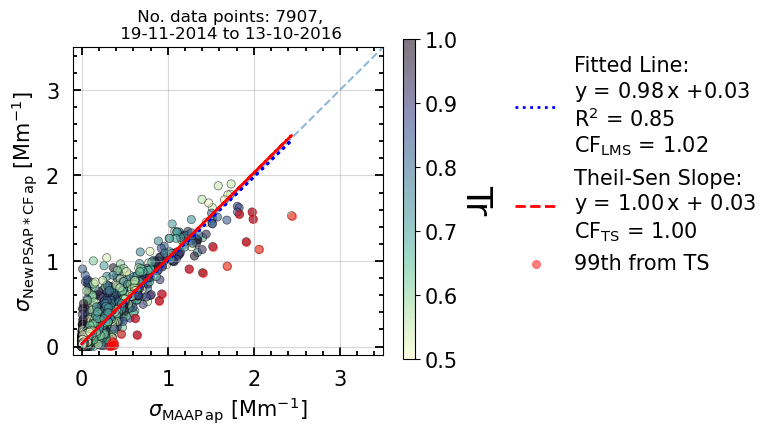

In [34]:
df_merged = fu_cf_abs.mergedfs(df_MAAP, df_newpsap637_hourly)#merge 
fig, dict_stats, df_anomalies = fu_cf_abs.create_regession_plot(df_merged, x_var='absorption', 
                                                          y_var='abs637 '+str(mean_or_median)+'_cf', 
                                                          c_var='Tr '+str(mean_or_median), set_max_value=3.5, dict_abs_labels={}, 
                                                          title='', vmin=0, vmax=1, percentile=99, clabel='Tr', 
                                                          xlabel='$\sigma_{\mathrm{MAAP\,ap}}$ [Mm$^{-1}$]', 
                                                          ylabel='$\sigma_{\mathrm{New\,PSAP * CF\,ap}}$ [Mm$^{-1}$]')

Colour volume mean_y


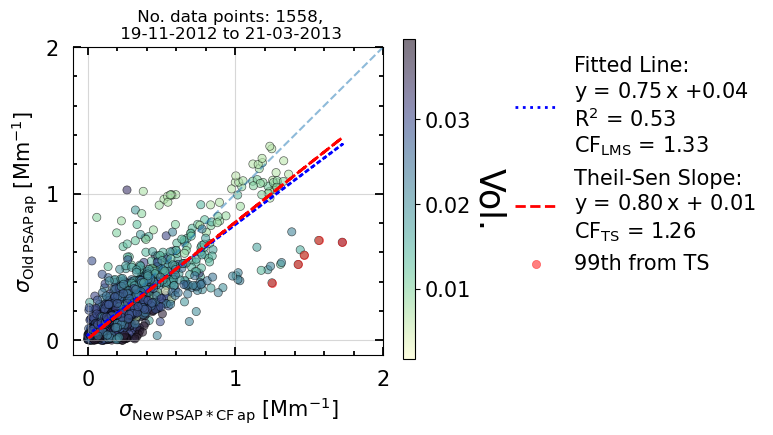

make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\\Old_PSAP_vs_New_PSAP_CF.jpeg
Correction factors: LMS = 1.325280339045099 TS = 1.256965133044538
Applying correction factor of 1.256965133044538
new variable: abs637 mean_cf


In [35]:
df_merged = fu_cf_abs.mergedfs(df_newpsap637_hourly, df_oldpsap637_hourly) 

fig, dict_stats, df_anomalies = fu_cf_abs.create_regession_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_cf', 
                                                               y_var='abs637 '+str(mean_or_median)+'_y', 
                                                               c_var='volume '+str(mean_or_median)+'_y', 
                                                               set_max_value=2, dict_abs_labels={}, 
                                                               title='', vmin=0, vmax=1, percentile=99, clabel='Vol.', 
                                                               xlabel='$\sigma_{\mathrm{New\,PSAP * CF\,ap}}$ [Mm$^{-1}$]', 
                                                               ylabel='$\sigma_{\mathrm{Old\,PSAP\,ap}}$ [Mm$^{-1}$]')


fu_cf_abs.save_plot(fig, name='Old_PSAP_vs_New_PSAP_CF')
for parameter in parameters:
    df_stats_table.loc['New PSAPxCF vs. Old PSAP', parameter] = dict_stats[parameter]
    
cf_ts = dict_stats['cf_TS']
cf_LMS = dict_stats['cf_LMS']
print("Correction factors: LMS = "+str(cf_LMS)+" TS = "+str(cf_ts))
cf_newPSAP_oldPSAP = cf_ts

df_oldpsap637_hourly = fu_cf_abs.apply_correction(df_oldpsap637_hourly, cf_newPSAP_oldPSAP, 
                                                  mean_or_median, var='abs637')

In [36]:
df_stats_table

,cf_LMS,cf_TS,coef,coef_ts,R2,length,start,stop
MAAP vs. New PSAP,0.609812,0.594981,1.64,1.68,0.85,7907,2014-11-19,2016-10-13
New PSAPxCF vs. Old PSAP,1.32528,1.256965,0.75,0.80,0.53,1558,2012-11-19,2013-03-21


Colour volume mean_y


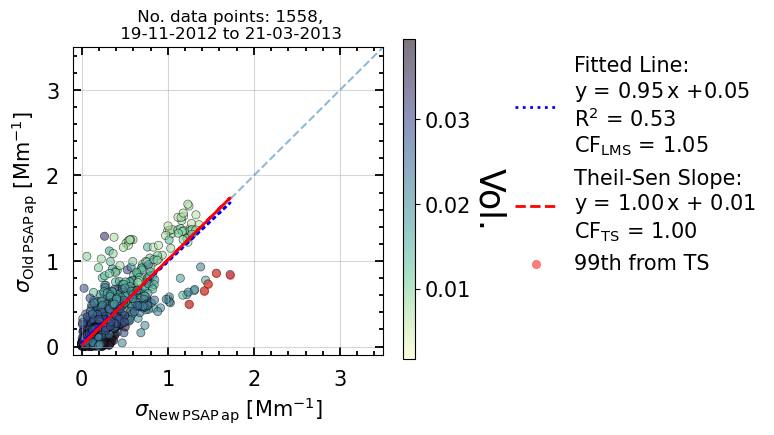

In [37]:
df_merged = fu_cf_abs.mergedfs(df_newpsap637_hourly, df_oldpsap637_hourly) #merge 
fig, dict_stats, df_anomalies = fu_cf_abs.create_regession_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_cf_x', 
                                                               y_var='abs637 '+str(mean_or_median)+'_cf_y', 
                                                               c_var='volume '+str(mean_or_median)+'_y', 
                                                               set_max_value=3.5, 
                                                               dict_abs_labels={}, 
                                                               title='', vmin=0, vmax=1, percentile=99, clabel='Vol.', 
                                                               xlabel='$\sigma_{\mathrm{New\,PSAP\,ap}}$ [Mm$^{-1}$]', 
                                                               ylabel='$\sigma_{\mathrm{Old\,PSAP\,ap}}$ [Mm$^{-1}$]')

In [38]:
df_oldpsapEBAS637_hourly = fu_cf_abs.hourly_resample(df_oldpsapEBAS637, cols=['abs637'])

Index(['abs637 mean', 'abs637 median', 'abs637 std', 'abs637 var'], dtype='object')


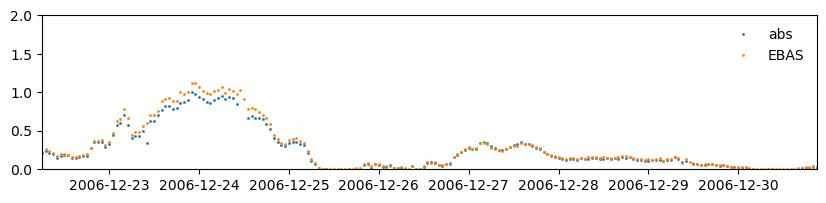

In [39]:
fig = fu_cf_abs.quick_timeseries_plot(df_oldpsap637_hourly, df_oldpsapEBAS637_hourly, var='abs637 mean',
                                 start='2006-12-22 06:00:00', end='2006-12-30 21:00:00')

In [40]:
df_oldpsapEBAS637_hourly = fu_cf_abs.hourly_resample(df_oldpsapEBAS637, cols=['abs637'])

Index(['abs637 mean', 'abs637 median', 'abs637 std', 'abs637 var'], dtype='object')


Colour volume mean


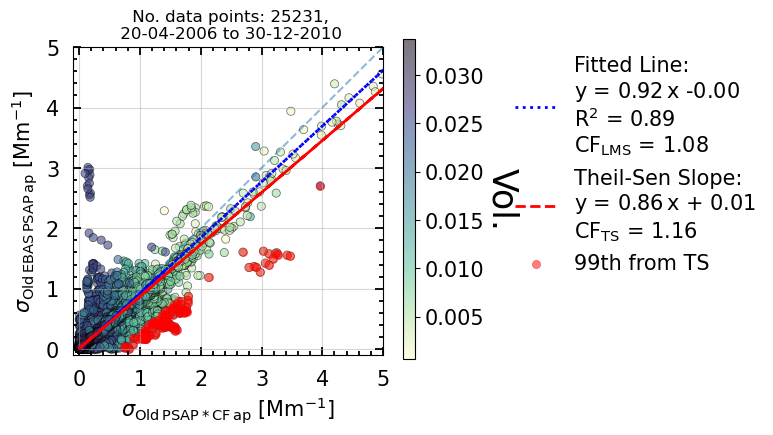

make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\\Old_PSAP_EBAS_vs_Old_PSAP_CF.jpeg
Correction factors: LMS = 1.082696848604723 TS = 1.1618293173605294
Applying correction factor of 1.1618293173605294
new variable: abs637 mean_cf


In [41]:
df_merged = fu_cf_abs.mergedfs(df_oldpsap637_hourly, df_oldpsapEBAS637_hourly) # merge 

fig, dict_stats, df_anomalies = fu_cf_abs.create_regession_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_cf', 
                                                               y_var='abs637 '+str(mean_or_median)+'_y', 
                                                               c_var='volume '+str(mean_or_median), set_max_value=5, 
                                                               dict_abs_labels={}, 
                                                               title='', vmin=0, vmax=1, percentile=99, clabel='Vol.', 
                                                               xlabel='$\sigma_{\mathrm{Old\,PSAP*CF\,ap}}$ [Mm$^{-1}$]', 
                                                               ylabel='$\sigma_{\mathrm{Old\,EBAS\,PSAP\,ap}}$ [Mm$^{-1}$]')

fu_cf_abs.save_plot(fig, name='Old_PSAP_EBAS_vs_Old_PSAP_CF')
for parameter in parameters:
    df_stats_table.loc['Old PSAP (EBAS) vs. Old PSAP CF', parameter] = dict_stats[parameter]
    
cf_ts = dict_stats['cf_TS']
cf_LMS = dict_stats['cf_LMS']
print("Correction factors: LMS = "+str(cf_LMS)+" TS = "+str(cf_ts))
cf_oldPSAP_oldPSAPEBAS = cf_ts

df_oldpsapEBAS637_hourly = fu_cf_abs.apply_correction(df_oldpsapEBAS637_hourly, cf_oldPSAP_oldPSAPEBAS, 
                                                      mean_or_median, var='abs637')

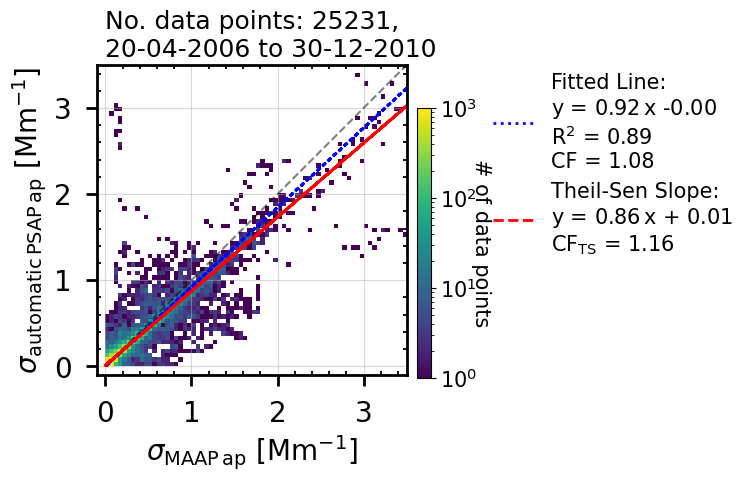

In [42]:
fig, ax = plt.subplots(figsize=(5,5))
fu_cf_abs.produce_density_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_cf', 
                               y_var='abs637 '+str(mean_or_median)+'_y', value_limit=3.5, 
                               step = 0.05, ax=ax)

fu_cf_abs.create_simple_regession_plot(df_merged, x_var='abs637 '+str(mean_or_median)+'_cf', 
                                   y_var='abs637 '+str(mean_or_median)+'_y', set_max_value=3.5, 
                                dict_abs_labels={}, 
                                title='', vmin=0, vmax=1, 
                                xlabel='$\sigma_{\mathrm{MAAP\,ap}}$ [Mm$^{-1}$]', 
                                ylabel='$\sigma_{\mathrm{automatic\,PSAP\,ap}}$ [Mm$^{-1}$]', 
                                show_points=False, loc_legend_out_box=1.25, ax=ax)

plt.show()

In [43]:
float_cols = ['cf_LMS', 'cf_TS', 'coef', 'coef_ts', 'R2', 'length']

df_stats_table[float_cols] = df_stats_table[float_cols].astype('float32')
df_stats_table[float_cols] = df_stats_table[float_cols].round(3)
df_stats_table['length'] = df_stats_table['length'].astype('int')

fu_cf_abs.save_df(df_stats_table, savepath+'\\stats_table', 
                  name='stats_table_intercomparsion', index=True, float_format='%.2f', format_data='.csv', header=False)

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\stats_table\stats_table_intercomparsion.csv


In [44]:
df = fu_cf_abs.append_all_dfs(df_oldpsapEBAS637_hourly, df_oldpsap637_hourly, df_newpsap637_hourly, df_MAAP, 
                    oldpsapEBASabsvar='abs637 mean', oldpsapabsvar='abs637 '+str(mean_or_median)+'_cf',
                    newpsapabsvar='abs637 '+str(mean_or_median)+'_cf',
                    maapabsvar='absorption')
fu_cf_abs.find_number_of_duplicate_indexs(df)

old PSAP EBAS
Start time: 2002-03-08 14:00:00 End time: 2010-12-30 21:00:00
old PSAP
Start time: 2006-04-20 17:00:00 End time: 2013-10-24 00:00:00
new PSAP
Start time: 2012-11-19 16:00:00 End time: 2016-10-13 08:00:00
MAAP
Start time: 2014-11-19 15:00:00 End time: 2023-04-17 08:00:00
Minimum value for EBAS: 0.000
Minimum value for EBAS: -15.571
Minimum value for EBAS: -3.616
Minimum value for EBAS: -2.727
Duplicate Rows except first occurrence based on all columns are: 0


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [45]:
df = fu_cf_abs.remove_outliers(df, var='abs637', top_percentile_value=99.99, keep_extreme_values=False)

Using the perecentile: 99.99
Smallest value: -1.721138539999389
Largest value: 13.299951525023648


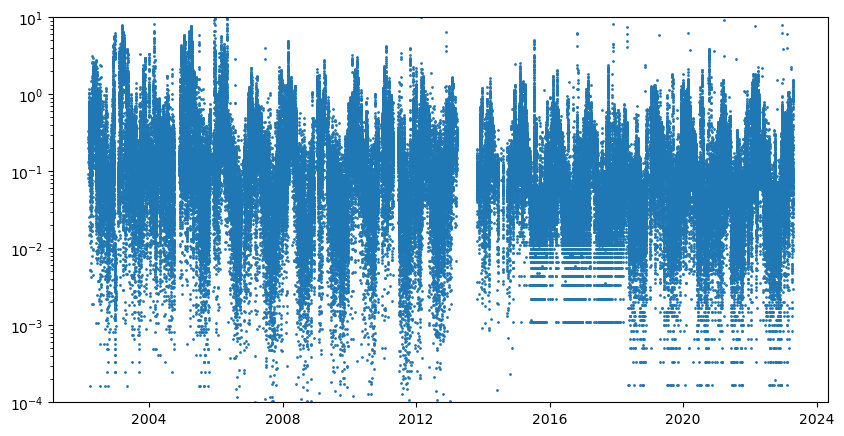

In [46]:
fig = fu_cf_abs.quick_log_plot(df)

In [47]:
df_abs525 = fu_cf_abs.convert_wavelength(df,lambda1=637,lambda2=525,abs_col='abs637',use_constant=True)
df_abs525 = df_abs525[['abs525']].copy()

df_abs525 = df_abs525[df_abs525 > 0]
df_abs637 = df[['abs637']].copy()
df_abs637 = df_abs637[df_abs637 > 0]

AAE = 1.0 is used to convert between wavelengths for abs637


return fig


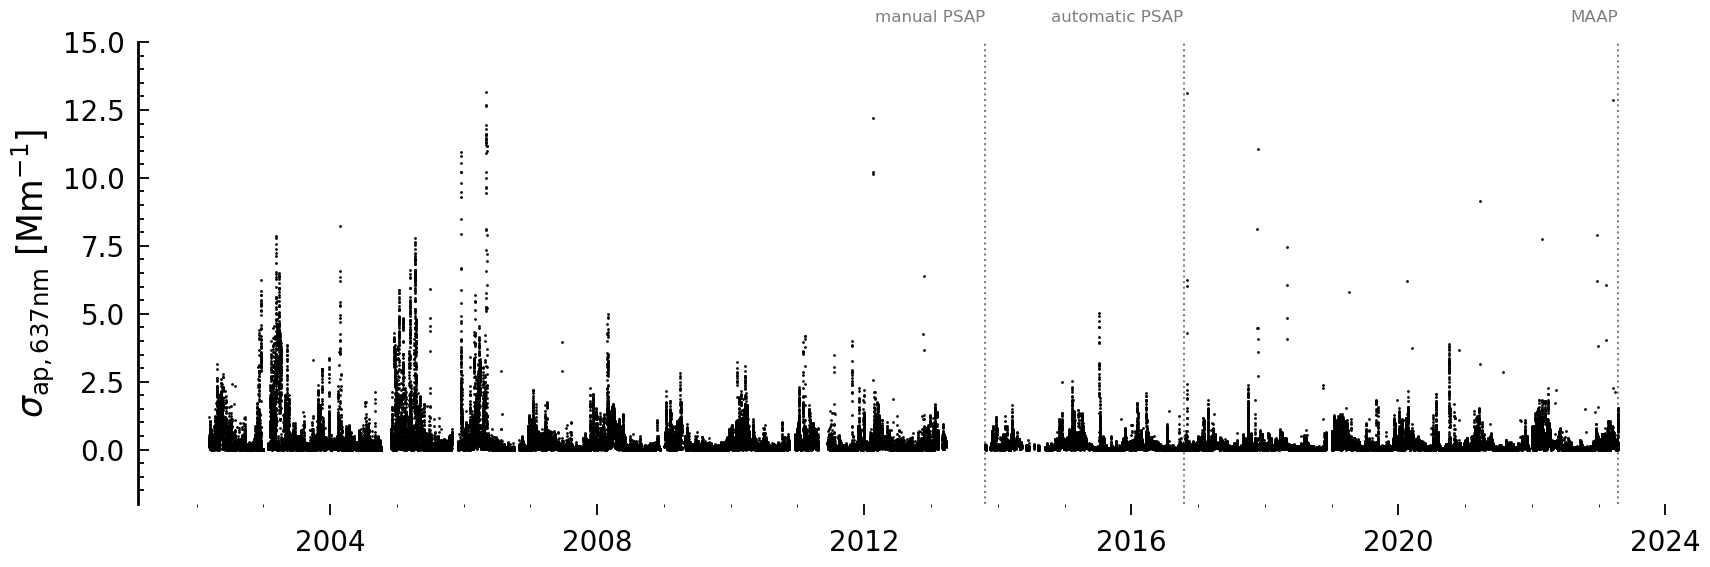

In [48]:
fig = fu_cf_abs.quick_plot(df_abs637, df_oldpsap637_hourly, df_newpsap637_hourly, df_MAAP, 'abs637', add_labels=True, 
                          ymax=15, ax=None)
plt.show()

In [49]:
fu_cf_abs.save_df(df_abs637, name='oldpsap_newpsap_maap', path=savepath+'\\absorption\\appended',
       float_format='%.3f')
fu_cf_abs.save_df(df_abs525, name='oldpsap_newpsap_maap_tunved525', path=savepath+'\\absorption\\appended',
       float_format='%.3f')

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap_tunved525.dat


Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var'],
      dtype='object')


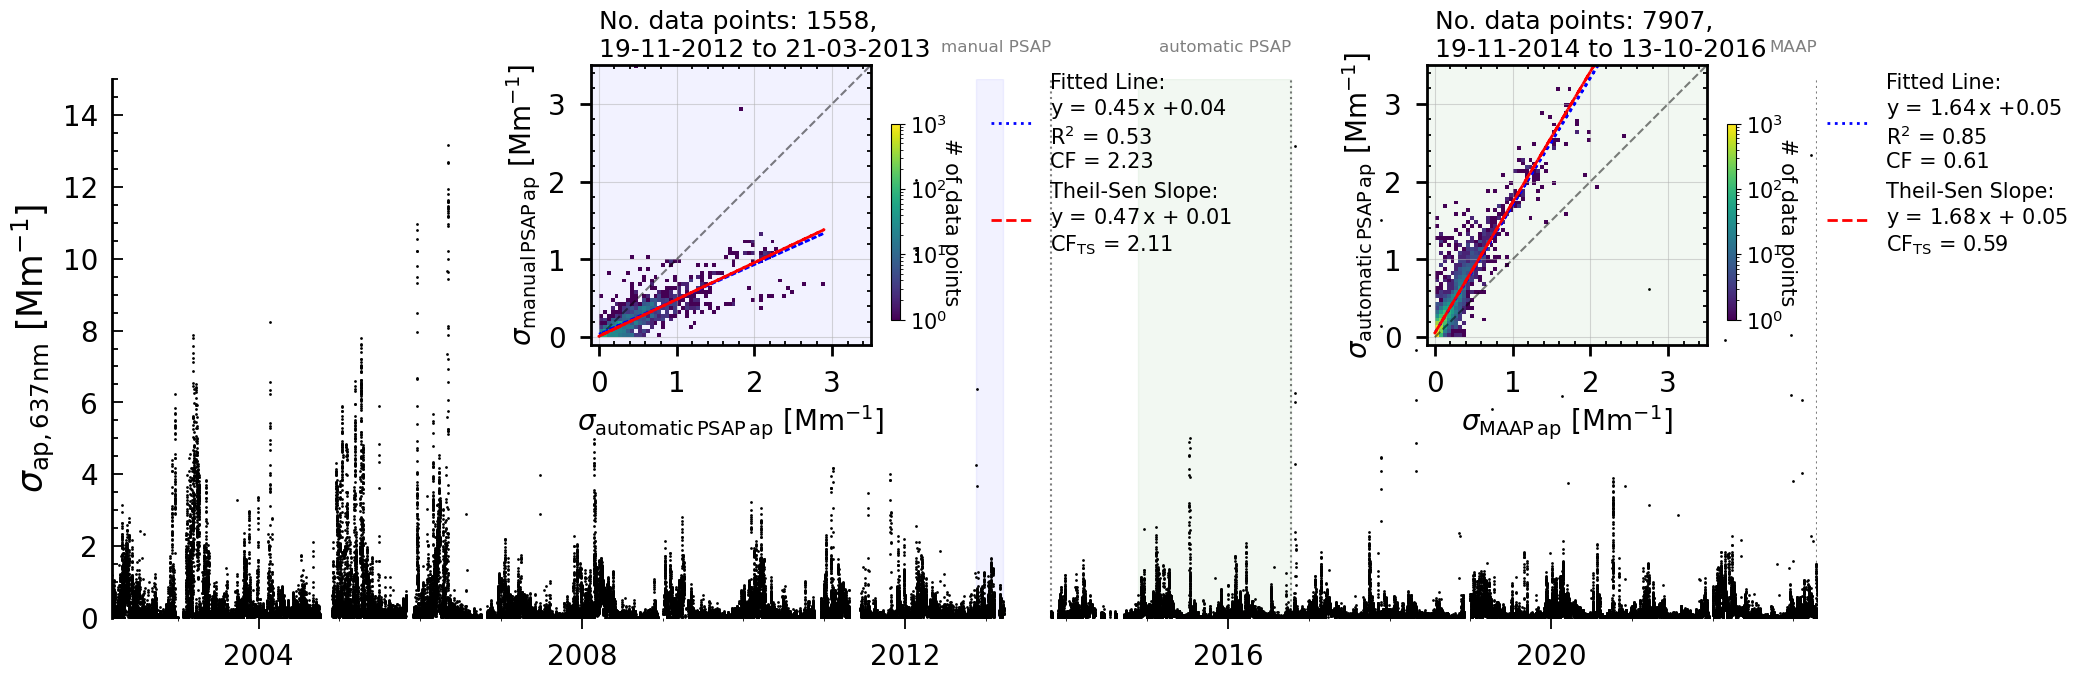

In [50]:
fig = fu_cf_abs.combination_timeseries_and_regression(df_abs637, df_newpsap637, 
                                                df_oldpsap637_hourly, df_newpsap637_hourly, df_MAAP, alpha=.05)

In [51]:
def gridspec(df_abs637, df_newpsap637, df_oldpsap637_hourly, df_newpsap637_hourly, 
             df_MAAP,mean_or_median='mean', alpha=0.1):
    fig = plt.figure(figsize=(8, 8))

    gs = gridspec.GridSpec(ncols=2, nrows=2, hspace = 0.2, wspace = 0.2, top = 1,
                           bottom = 0, left = 0, right = 1)
    # y x
    # create an ax with gs
    ax = fig.add_subplot(gs[0, 0:1])
    ax.text(0.5, 0.5, '', fontsize=17, color='red', transform=ax.transAxes, 
            horizontalalignment='center', verticalalignment='center')

    ax = fig.add_subplot(gs[0, 1:2])
    ax.text(0.5, 0.5, '', fontsize=17, color='red', transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center')

    ax = fig.add_subplot(gs[1, 0:2])
    ax.text(0.5, 0.5, 'c)', fontsize=17, color='red', transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center')

    plt.show()
    return fig

Index(['filter_num mean', 'filter_num median', 'filter_num std',
       'filter_num var', 'abs637 mean', 'abs637 median', 'abs637 std',
       'abs637 var', 'scat550 mean', 'scat550 median', 'scat550 std',
       'scat550 var', 'Tr mean', 'Tr median', 'Tr std', 'Tr var'],
      dtype='object')


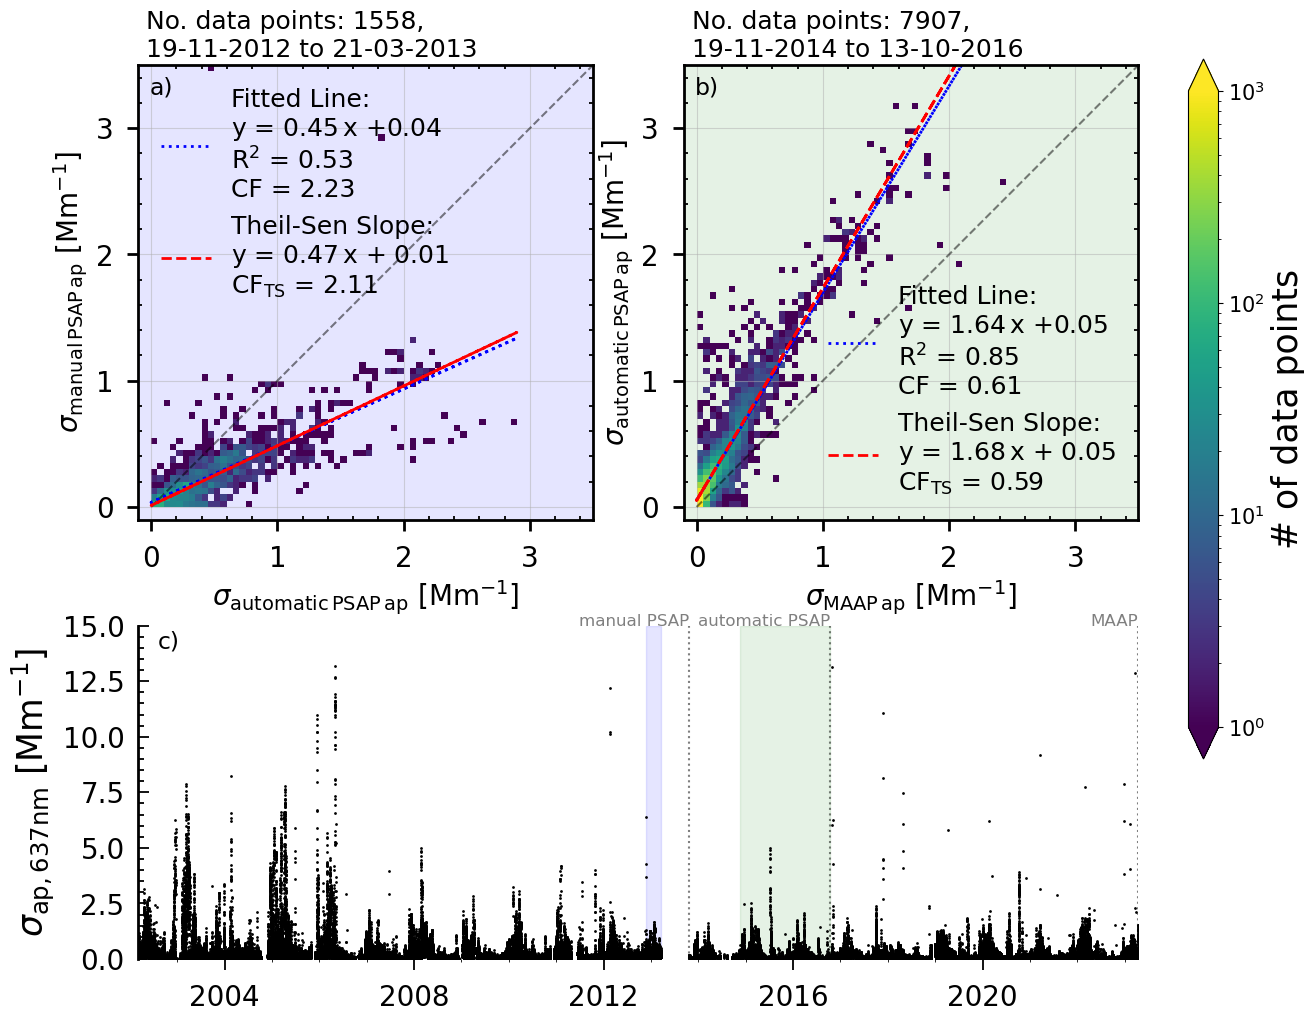

In [52]:
fig = fu_cf_abs.gridspec_subplots(df_abs637, df_newpsap637, df_oldpsap637_hourly, df_newpsap637_hourly, 
             df_MAAP, mean_or_median='mean', alpha=0.1)

In [55]:
fu_cf_abs.save_plot(fig, savepathplots, name='Figure1', formate='.png', dpi=300)

make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\Figure1.png
